# Projet 6 : Classifiez automatiquement des biens de consommation

## CNN (Reseau de neuronnes convolutifs)

In [1]:

# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import jyquickhelper
import numpy as np
import pandas as pd
import os
import pickle
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Réduction dimension
from sklearn.manifold import TSNE
# Clustering
from sklearn.cluster import KMeans
# CNN Applications Keras
import keras
from keras.preprocessing import image
import tensorflow as tf
# LDA, NMF
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Warnings
import warnings
warnings.filterwarnings('ignore')


2023-05-08 08:05:31.820659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Données de travail

In [2]:
# Chargement du jeu de données
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

# Ajout variable images
image_path = '/Users/danongohou/Desktop/P6/Images/'
df['image_loc'] = [image_path + row for row in df['image']]

# Ajout de la variable  Categorie
df['categorie'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0][2:].strip())

data = df[['image', 'image_loc', 'categorie']]
data.head()

,image,image_loc,categorie
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6/Images/55b85ea15a...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6/Images/7b72c92c2f...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6/Images/64d5d4a258...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6/Images/d4684dcdc7...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6/Images/6325b6870c...,Home Furnishing


### Création du modèle préentrainé

In [3]:
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input
from keras.applications import ResNet152


# Instanciation du modèle
model = ResNet152(weights='imagenet', include_top=False)

# Résumé de l'architecture du modèle
model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                       

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv3_block5_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, None, None,   0          ['conv3_block5_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block5_2_conv (Conv2D)   (None, None, None,   147584      ['conv3_block5_1_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block5_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block7_out (Activation)  (None, None, None,   0           ['conv3_block7_add[0][0]']       
                                512)                                                              
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, None, None,   65664       ['conv3_block7_out[0][0]']       
                                128)                                                              
                                                                                                  
 conv3_block8_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block8_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, None, None,   0          ['conv4_block2_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block2_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block5_1_relu (Activatio  (None, None, None,   0          ['conv4_block5_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block5_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block5_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, None, None,   0          ['conv4_block5_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block7_out[0][0]']       
                                256)                                                              
                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block8_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, None, None,   0          ['conv4_block8_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block10_add (Add)        (None, None, None,   0           ['conv4_block9_out[0][0]',       
                                1024)                             'conv4_block10_3_bn[0][0]']     
                                                                                                  
 conv4_block10_out (Activation)  (None, None, None,   0          ['conv4_block10_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block11_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block10_out[0][0]']      
                                256)                                                              
          

 conv4_block13_2_relu (Activati  (None, None, None,   0          ['conv4_block13_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block13_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block13_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block13_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block13_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block13_add (Add)        (None, None, None,   0           ['conv4_block12_out[0][0]',      
          

                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block16_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block16_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block16_2_relu (Activati  (None, None, None,   0          ['conv4_block16_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block19_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block19_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block19_1_relu (Activati  (None, None, None,   0          ['conv4_block19_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block19_1_relu[0][0]']   
                                256)                                                              
          

 conv4_block21_add (Add)        (None, None, None,   0           ['conv4_block20_out[0][0]',      
                                1024)                             'conv4_block21_3_bn[0][0]']     
                                                                                                  
 conv4_block21_out (Activation)  (None, None, None,   0          ['conv4_block21_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block22_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block21_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block22_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block22_1_conv[0][0]']   
 lization)

                                                                                                  
 conv4_block24_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block24_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block24_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block24_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block24_add (Add)        (None, None, None,   0           ['conv4_block23_out[0][0]',      
                                1024)                             'conv4_block24_3_bn[0][0]']     
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block27_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block27_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block27_2_relu (Activati  (None, None, None,   0          ['conv4_block27_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block27_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block27_2_relu[0][0]']   
                                1024)                                                             
          

 conv4_block30_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block30_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block30_1_relu (Activati  (None, None, None,   0          ['conv4_block30_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block30_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block30_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block30_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block30_2_conv[0][0]']   
 lization)

                                                                                                  
 conv4_block32_out (Activation)  (None, None, None,   0          ['conv4_block32_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block33_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block32_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block33_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block33_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_blo

                                1024)                                                             
                                                                                                  
 conv4_block35_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block35_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block35_add (Add)        (None, None, None,   0           ['conv4_block34_out[0][0]',      
                                1024)                             'conv4_block35_3_bn[0][0]']     
                                                                                                  
 conv4_block35_out (Activation)  (None, None, None,   0          ['conv4_block35_add[0][0]']      
                                1024)                                                             
          

 conv5_block2_1_relu (Activatio  (None, None, None,   0          ['conv5_block2_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block2_1_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, None, None,   2048       ['conv5_block2_2_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, None, None,   0          ['conv5_block2_2_bn[0][0]']      
 n)       

### Création des features

In [4]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np


# Liste des features
images_features = []

for rep_image in data['image_loc']:
   
    # Charger l'image et la redimensionner à la taille requise de 224×224 pixels.
    img = Image.open(rep_image)
    img = img.resize((224,224))

    # Convertir les pixels en un tableau NumPy afin de pouvoir travailler avec dans Keras
    img = image.img_to_array(img)
    
    # Redimensionnement
    img = np.expand_dims(img, axis=0)
    
    # Préparer de nouvelles entrées pour le réseau.
    img = preprocess_input(img)

    # obtenir une prédiction de la probabilité d'appartenance de l'image à chacun des 1000 types d'objets connus.
    pred_feature = model.predict(img)
    
    # Ajouter la feature prédite en nparray à la liste
    images_features.append(np.array(pred_feature).flatten())

images_features = np.array(images_features)


1/1 [==============================] - 0s 224ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 0s 229ms/step


1/1 [==============================] - 0s 233ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 229ms/step


#### DataFrame des vecteurs de features

In [12]:
# Vérifie si le répertoire 'sauvegarde' existe, sinon le crée
if not os.path.exists('cnn/'):
    os.makedirs('cnn/')

# Dataframe de vecteurs des features issus de ResNet152
df_features_vectors = pd.DataFrame.from_records(images_features)

# Sauvegarde du dataframe des vectors BOVW ResNet152
with open('cnn/df_features_vectors.pickle', 'wb') as f:
    pickle.dump(df_features_vectors, f, pickle.HIGHEST_PROTOCOL)


### PCA

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Charger les descripteurs ORB extraits dans la question précédente
with open('cnn/df_features_vectors.pickle', 'rb') as f:
    df_features_vectors = pickle.load(f)

    
# Réduire la dimensionnalité avec PCA
pca = PCA(n_components=0.99)
df_pca = pca.fit_transform(df_features_vectors)

# Sauvegarde du dataframe des vectors BOVW ResNet152
with open('cnn/df_pca.pickle', 'wb') as f:
    pickle.dump(df_pca, f, pickle.HIGHEST_PROTOCOL)
    
print(df_features_vectors.shape) 
print(df_pca.shape)

(1050, 100352)
(1050, 970)


### TSNE

In [26]:

import matplotlib.pyplot as plt
import seaborn as sns


# Charger les descripteurs ORB extraits dans la question précédente
with open('cnn/df_features_vectors.pickle', 'rb') as f:
    df_features_vectors = pickle.load(f)

    
liste_param = [20, 30, 40, 50, 70, 80]
results_resnet = list()
tsne_results = []
for i in liste_param:
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=500,random_state=seed)
    tsne_results = tsne.fit_transform(df_features_vectors)
    results_resnet.append(tsne_results)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 1.460s...
[t-SNE] Computed neighbors for 1050 samples in 5.954s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 153.431240
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.164017
[t-SNE] KL divergence after 500 iterations: 1.665649
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1050 samples in 1.382s...
[t-SNE] Computed neighbors for 1050 samples in 5.411s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 162.716203
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.923019
[t-SNE] KL divergence after 500 iterations: 1.598142
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 1.361s...
[t-SNE] Computed neighbors for 1050 samples i

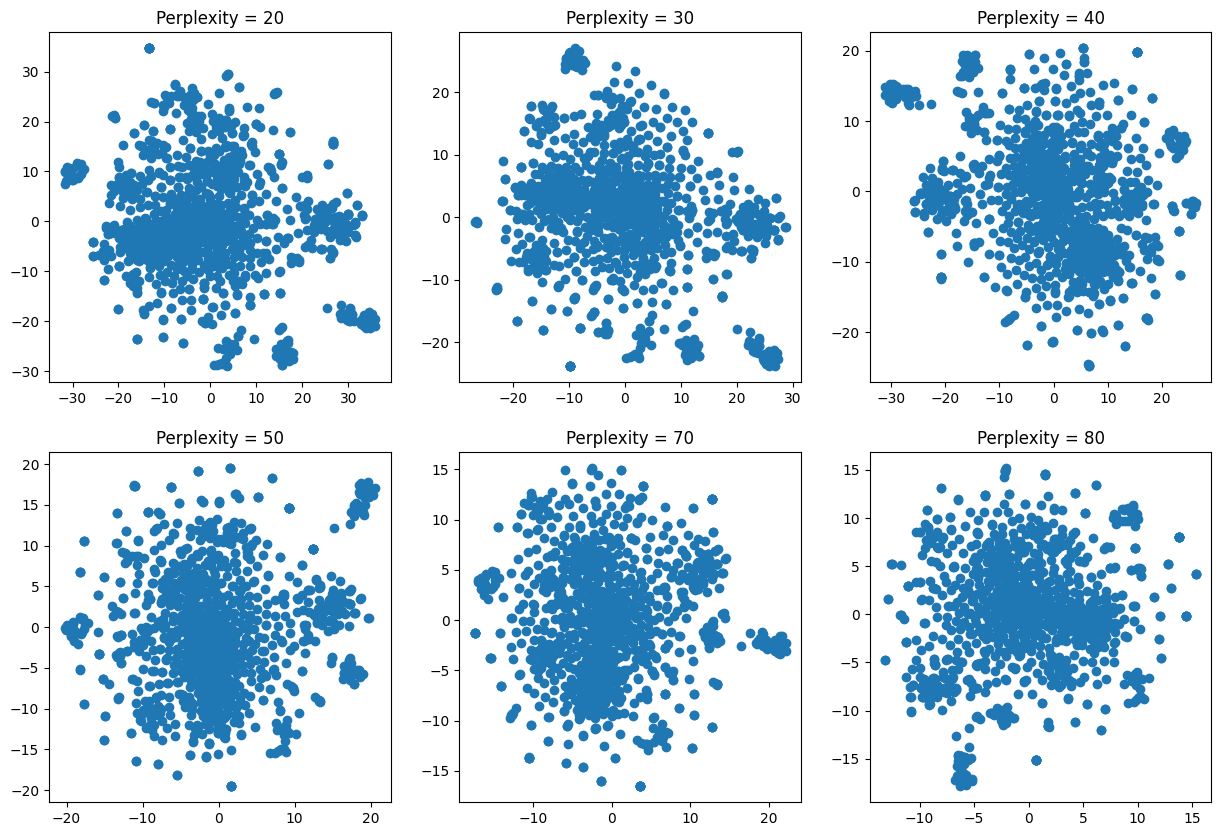

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, perplexity in enumerate(liste_param):
    row = i // 3
    col = i % 3
    axs[row, col].scatter(results_resnet[i][:, 0], results_resnet[i][:, 1])
    axs[row, col].set_title(f"Perplexity = {perplexity}")
plt.show()


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 1.576s...
[t-SNE] Computed neighbors for 1050 samples in 7.520s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 183.127824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.908524
[t-SNE] KL divergence after 500 iterations: 1.234686


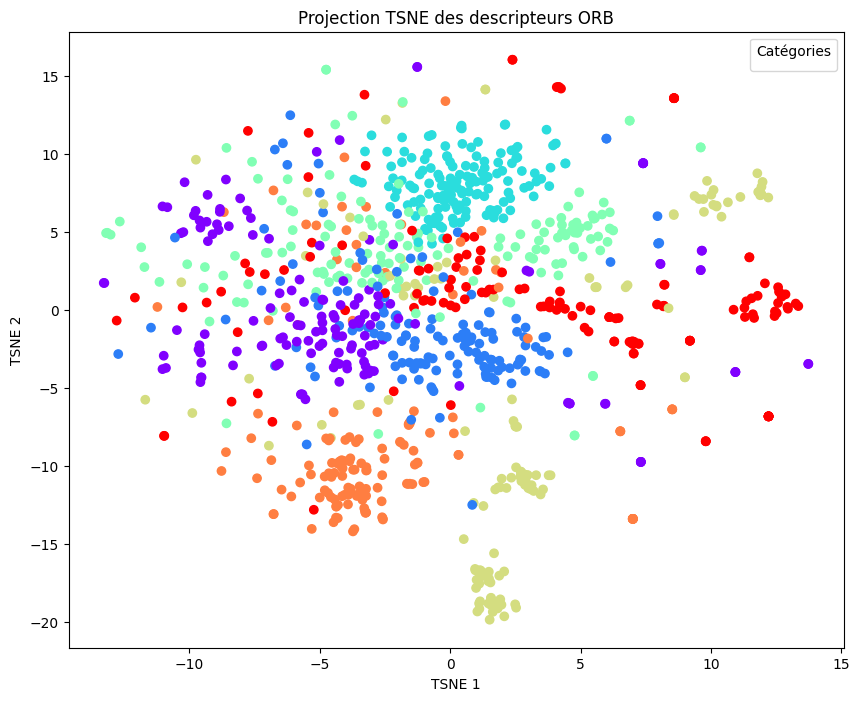

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Charger les descripteurs ORB extraits dans la question précédente
with open('cnn/df_features_vectors.pickle', 'rb') as f:
    df_features_vectors = pickle.load(f)

# Réduction de dimension tsne
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=500)
X_tsne = tsne.fit_transform(df_features_vectors)

categories = data['categorie'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
color_map = dict(zip(categories, colors))

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=data['categorie'].map(color_map))
plt.legend(*scatter.legend_elements(), title="Catégories")
plt.title("Projection TSNE des descripteurs CNN")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()

# Dataframe pour clustering
df_tsne = pd.DataFrame({'tsne1' : X_tsne[:, 0],
                        'tsne2' : X_tsne[:, 1],
                        'categorie' : data['categorie'],
                        'image': data['image'],
                        'image_loc': data['image_loc']})

In [59]:
df_tsne.shape

(1050, 6)

In [7]:
df_tsne.head()

,tsne1,tsne2,categorie,image,image_loc
0,-9.586416,-2.732800,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6/Images/55b85ea15a...
1,-6.715812,-3.590441,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6/Images/7b72c92c2f...
2,-4.364499,-1.778564,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6/Images/64d5d4a258...
3,-9.824665,6.068743,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6/Images/d4684dcdc7...
4,-9.758207,6.355252,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6/Images/6325b6870c...


### KMEANS

In [20]:
# Instanciation du modèle KMeans avec les meilleurs paramètres
cols = ['tsne1', 'tsne2']

kmeans_tsne = KMeans(n_clusters=7, init='k-means++', 
                     n_init=10, max_iter=200, random_state=42).fit(df_tsne[cols])

# Ajout de l'assignation du cluster au dataframe
kmeans_tsne_labels = kmeans_tsne.labels_
df_tsne['kmeans_labels'] = kmeans_tsne.labels_

In [46]:
df_tsne_copy = df_tsne.copy()
df_tsne_copy.head()

,tsne1,tsne2,categorie,image,image_loc,kmeans_labels
0,-9.586416,-2.732800,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6/Images/55b85ea15a...,3
1,-6.715812,-3.590441,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6/Images/7b72c92c2f...,3
2,-4.364499,-1.778564,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6/Images/64d5d4a258...,4
3,-9.824665,6.068743,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6/Images/d4684dcdc7...,3
4,-9.758207,6.355252,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6/Images/6325b6870c...,3


### Fonction de mapping entre clusters obetenus avec les vraies catégories

In [47]:
# Function to map predicted labels to true category names
def get_named_labels_and_num_to_name(pred_labels, true_categ_names_list):
    label_num_to_name = {} # Créer un dictionnaire vide pour stocker les noms de catégorie réelle correspondants aux labels prédits

    for pred_label in sorted(set(pred_labels)): # Boucle pour chaque label prédit unique dans la liste de labels prédits
        # Extraction des indices des éléments correspondants à ce label dans la liste "pred_labels"
        indices = [i for i in range(len(pred_labels)) if pred_labels[i] == pred_label] 

        # Extraction des noms de catégories réelles correspondants aux indices dans la liste "true_categ_names_list"
        categ_names = [true_categ_names_list[i] for i in indices] 

        # Création d'une série Pandas avec les noms de catégories réelles extraits, 
        # puis utilisation de la méthode "value_counts()" pour obtenir le nombre d'occurrences de chaque nom de catégorie réelle
        categ_name_counts = pd.Series(categ_names).value_counts() 

        # Utilisation de la méthode "idxmax()" pour obtenir le nom de catégorie réelle le plus fréquent dans la série
        most_common_categ_name = categ_name_counts.idxmax() 

        # Stockage du label prédit et du nom de catégorie réelle correspondant dans le dictionnaire "label_num_to_name"
        label_num_to_name[pred_label] = most_common_categ_name

        # Remplacement de chaque occurrence du label prédit par le nom de catégorie réelle correspondant dans la liste "pred_labels"
        pred_labels = [x if x != pred_label else most_common_categ_name for x in pred_labels]

    return label_num_to_name # Renvoi du dictionnaire "label_num_to_name" qui mappe les labels prédits aux noms de catégories réelles correspondantes



- ### Mapping

In [48]:
categ_names = df_tsne_copy["categorie"]
predicted_labels = df_tsne_copy['kmeans_labels']

label_num_to_name = get_named_labels_and_num_to_name(predicted_labels, categ_names)
label_num_to_name

{0: 'Beauty and Personal Care',
 1: 'Watches',
 2: 'Computers',
 3: 'Home Furnishing',
 4: 'Baby Care',
 5: 'Home Decor & Festive Needs',
 6: 'Kitchen & Dining'}

In [49]:
df = {'Beauty and Personal Care': '0',
      'Watches': '1', 
      'Computers': '2', 
      'Home Furnishing': '3', 
      'Baby Care': '4', 
      'Home Decor & Festive Needs': '5',
      'Kitchen & Dining': '6'}

df_tsne_copy['true_labels'] = df_tsne_copy['categorie'].map(df)

In [52]:
df_tsne_copy.head() 

,tsne1,tsne2,categorie,image,image_loc,kmeans_labels,true_labels
0,-9.586416,-2.732800,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6/Images/55b85ea15a...,3,3
1,-6.715812,-3.590441,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6/Images/7b72c92c2f...,3,4
2,-4.364499,-1.778564,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6/Images/64d5d4a258...,4,4
3,-9.824665,6.068743,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6/Images/d4684dcdc7...,3,3
4,-9.758207,6.355252,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6/Images/6325b6870c...,3,3


### Graph TSNE selon les vraies catégories

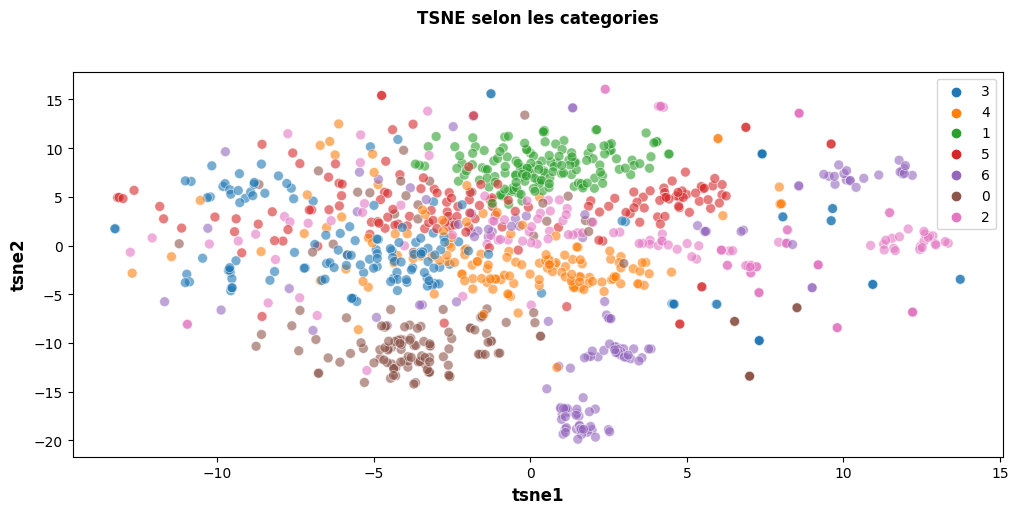

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="true_labels",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_copy,
    legend="brief")

plt.title('TSNE selon les categories', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

### Grapgh TSNE selon les predictions KMEANS

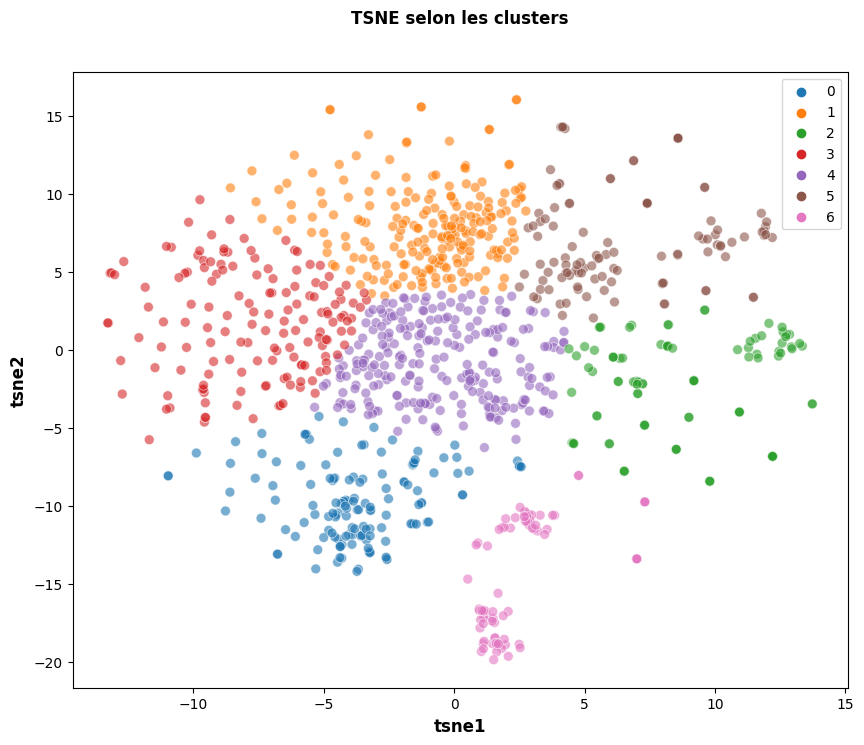

In [54]:
import pandas as pd
import numpy as np
from sklearn import cluster, metrics
from sklearn.cluster import KMeans


plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="kmeans_labels",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_copy,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

### Score ARI

In [55]:

df_tsne_copy.head()

,tsne1,tsne2,categorie,image,image_loc,kmeans_labels,true_labels
0,-9.586416,-2.732800,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6/Images/55b85ea15a...,3,3
1,-6.715812,-3.590441,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6/Images/7b72c92c2f...,3,4
2,-4.364499,-1.778564,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6/Images/64d5d4a258...,4,4
3,-9.824665,6.068743,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6/Images/d4684dcdc7...,3,3
4,-9.758207,6.355252,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6/Images/6325b6870c...,3,3


In [58]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import cluster, metrics

true_labels = df_tsne_copy['true_labels']
kmeans_labels = df_tsne_copy['kmeans_labels']

ari = adjusted_rand_score(true_labels, kmeans_labels) 
print("ARI :", ari) 


ARI : 0.3094178026308519
